# In this file we fit our model with the real data.

In [296]:
from datetime import datetime
import random

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import norm, chi2

from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox  

from Garch import GARCH

#### Define helper functions 

In [297]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')  
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")

    if result[1] <= 0.05:
        print(" The series is stationary (reject H0)")
    else:
        print(" The series is non-stationary (fail to reject H0)")

In [298]:
def generate_ar_data(ar_coef, T):
    res = [0]
    for t in range(1,T):
        res.append(ar_coef * res[-1] + random.gauss(0, 1))

    return res

In [299]:
def likelihood_ratio_test(ll_null: float, ll_alternative: float, df: int):
    if df <= 0:
        raise ValueError("Degrees of freedom must be positive.")
    if ll_alternative < ll_null:
        raise ValueError("ll_null should be smaller than ll_alternative.")
    
    # Compute test statistic
    lr_stat = 2 * (ll_alternative - ll_null)
    
    # Compute p-value
    p_value = 1 - chi2.cdf(lr_stat, df)
    
    return p_value

In [ ]:
def merge_cleanup(prices_df, union_sentiment_df, stock_name):
    """
    Cleans and merges stock price data with sentiment data. Use stock sentiment when available; otherwise, replace it with market sentiment.


    Parameters
    ----------
    prices_df : pandas.DataFrame
        DataFrame containing stock price data with a datetime index.
    union_sentiment_df : pandas.DataFrame
        DataFrame containing sentiment data with a datetime index.
       
    stock_name : str
        The stock name (e.g., "Tesla", "Microsoft") as found in the "News" column of `union_sentiment_df`. 
        This is used to filter stock-specific sentiment data.

    Returns
    -------
    pandas.DataFrame
        A merged DataFrame with sentiment data adjusted according to the selected option.
    """
    stocksentiment_df = union_sentiment_df[union_sentiment_df['News'] == stock_name] 
    marketsentiment_df = union_sentiment_df[union_sentiment_df['News'] == 'Market']

    # On days where there is no stock sentiment, we replace it with market sentiment. 
    # On days with, we just use stock sentiment alone

    agg_func = {
        'pos_sentiment': 'mean',
        'neg_sentiment': 'mean',
        'neutral_sentiment': 'mean'}
    column_rename = {
        'pos_sentiment': 'mean_pos_sentiment',
        'neg_sentiment': 'mean_neg_sentiment',
        'neutral_sentiment': 'mean_neutral_sentiment'}
    #stocksentiment_df = stocksentiment_df.drop(columns=['adjusted_date'])
    #marketsentiment_df = marketsentiment_df.drop(columns=['adjusted_date'])
    stocksentiment_df_agg = stocksentiment_df.groupby(by='adjusted_date').agg(agg_func).rename(columns=column_rename).reset_index()
    stocksentiment_df_agg['News'] = stock_name
    marketsentiment_df_agg = marketsentiment_df.groupby(by='adjusted_date').agg(agg_func).rename(columns=column_rename).reset_index()
    marketsentiment_df_agg['News'] = 'Market'
    stocksentiment_df_agg.index = pd.DatetimeIndex(stocksentiment_df_agg['adjusted_date'])
    marketsentiment_df_agg.index = pd.DatetimeIndex(marketsentiment_df_agg['adjusted_date'])
    data_with_sentiment = prices_df.join(stocksentiment_df_agg, how='left')#.join(vix[['VIX Close']], how='left')
    data_with_sentiment = data_with_sentiment.join(marketsentiment_df_agg, how='left',lsuffix= stock_name, rsuffix= 'market')#.join(vix[['VIX Close']], how='left')
    #print(data_with_sentiment)
    data_with_sentiment.rename(columns={
        'mean_pos_sentimenttesla': 'mean_pos_sentiment',
        'mean_neg_sentimenttesla': 'mean_neg_sentiment',
        'mean_neutral_sentimenttesla': 'mean_neutral_sentiment',
        'Newstesla':'News'}, inplace=True)
    
    sentiment_columns = ["mean_pos_sentiment", "mean_neg_sentiment", "mean_neutral_sentiment",'News']
    
    stock_columns = [col for col in sentiment_columns]
    market_columns = [col + "market" for col in sentiment_columns]
    # Ensure stock_columns and market_columns are correctly aligned
    for stock_col, market_col in zip(stock_columns, market_columns):
        data_with_sentiment[stock_col] = data_with_sentiment[stock_col].where(
        data_with_sentiment[stock_col].notna(),  # Keep stock sentiment if it's NOT NaN
        data_with_sentiment[market_col]  # Otherwise, replace with market sentiment
        )

    #rename_columns = {col + stock_name : col for col in sentiment_columns}
    #data_with_sentiment.rename(columns=rename_columns, inplace=True)
    market_sentiment_cols = [col + "market" for col in sentiment_columns]
    data_with_sentiment.drop(columns=market_sentiment_cols, inplace=True)
    #display(data_with_sentiment)

    return data_with_sentiment



## 1. Load Data


In [ ]:
# Load S&P data
prices_df = pd.read_csv('../data/Tesla/tesla_prices.csv')
prices_df.index = pd.to_datetime(prices_df['Date'], format='%Y-%m-%d %H:%M:%S%z', utc=True).dt.date

tesla_sentiment = pd.read_csv('../data/Tesla/tesla_gpt_summarised_sentiments.csv')
market_sentiment = pd.read_csv('../data/S&P_market/market_gpt_summarised_sentiments.csv')

# Load US interest rate data
#t_rates_df = pd.read_csv('../data/daily-treasury-rates.csv')
#t_rates_df.index = pd.DatetimeIndex(t_rates_df['Date'])
#t_rates_df = t_rates_df.drop(columns=['Date','Unnamed: 11',	'Unnamed: 12', '26 WEEKS BANK DISCOUNT', '26 WEEKS COUPON EQUIVALENT'])

## Data Cleaning

In [ ]:
tesla_sentiment = tesla_sentiment.drop(columns = 'Unnamed: 0')
market_sentiment = market_sentiment.drop(columns = 'Unnamed: 0')
tesla_sentiment['News'] = 'tesla'
market_sentiment['News'] = 'Market'
tesla_sentiment['adjusted_date'] = pd.to_datetime(tesla_sentiment['adjusted_date'], format="%d/%m/%y").dt.strftime("%Y-%m-%d")
tesla_sentiment_with_market = pd.concat([tesla_sentiment, market_sentiment],ignore_index=True)
tesla_sentiment_with_market.index = pd.DatetimeIndex(tesla_sentiment_with_market['adjusted_date'])
tesla_sentiment_with_market = tesla_sentiment_with_market.drop(columns = 'adjusted_date')


In [ ]:
relevant_columns_final = ['Date','log_returns','mean_pos_sentiment','mean_neg_sentiment','mean_neutral_sentiment']

#Final df
tesla_final = merge_cleanup(prices_df, tesla_sentiment_with_market,'tesla')
tesla_final = tesla_final[relevant_columns_final]
tesla_final = tesla_final.dropna()
tesla_final = tesla_final[1:]



## GARCH X Model Function

In [304]:
def train_model(log_returns,exo_sentiment, log_returns_scale_factor, exo_scale_factor, use_constraints, method = 'L-BFGS-B', z = 1):
    garch_with_sentiment = GARCH(p=1, q=1, z=z, verbose=True)
    garch_with_sentiment.train(log_returns_scale_factor*log_returns, x = exo_scale_factor * exo_sentiment,use_constraints= use_constraints, method = method)
    return garch_with_sentiment.summary()



    

In [ ]:
exo_sentiment = ['mean_pos_sentiment', 'mean_neg_sentiment','mean_neutral_sentiment']
neg_sentiment = ['mean_neg_sentiment']



## GARCH Baseline

In [ ]:
#GARCH Baseline
train_model(tesla_final['log_returns'][10:], tesla_final[neg_sentiment][10:],1000,10,False,'SLSQP', 0)

Optimising...
Optimising finished in 3.849s
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 8.337579299164906
       x: [ 4.090e+00 -2.675e+00 -1.103e-01]
     nit: 43
     jac: [-7.951e-05 -1.903e-04 -6.520e-04]
    nfev: 187
    njev: 43
{'omega': 59.742524925158776, 'alpha': 0.06889154237808952, 'beta': 0.895522032504999, 'gamma': array([], shape=(0, 1), dtype=float64)}


,coef,std err,t,P>|t|
omega,59.742525,19.170459,3.116385,9.367392e-04
alpha,0.068892,0.013267,5.192750,1.212449e-07
beta,0.895522,0.020342,44.022617,9.604858e-255


### Garch with 3 exo

In [ ]:
## V2_2 with 3 exo variables
train_model(tesla_final['log_returns'][10:], tesla_final[exo_sentiment][10:],100,10,False,'SLSQP')

Optimising...
Optimising finished in 9.165s
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 3.7324328935868576
       x: [-8.137e+00 -2.562e+00 -1.213e-01 -3.977e+00 -5.131e+00
           -8.993e+01]
     nit: 93
     jac: [ 1.192e-06  2.366e-05  2.547e-04 -2.086e-07  5.960e-06
            0.000e+00]
    nfev: 664
    njev: 93
{'omega': 0.000292490828812872, 'alpha': 0.07713428428029827, 'beta': 0.8857721333702432, 'gamma': array([[1.87406302e-02, 5.91207913e-03, 8.77483191e-40]])}


,coef,std err,t,P>|t|
omega,2.924908e-04,1.516457,1.928778e-04,4.999231e-01
alpha,7.713428e-02,0.016565,4.656390e+00,1.784816e-06
beta,8.857721e-01,0.033296,2.660262e+01,1.098476e-123
gamma[0],1.874063e-02,0.020070,9.337548e-01,1.753074e-01
gamma[1],5.912079e-03,0.017283,3.420739e-01,3.661770e-01
gamma[2],8.774832e-40,0.057887,1.515858e-38,5.000000e-01


In [ ]:
## V2_2 with PCA
# ! pip install scikit-learn
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca_tesla = pca.fit_transform(tesla_final[exo_sentiment])
train_model(tesla_final['log_returns'][10:], pca_tesla[10:],1000,10,False,'SLSQP')

Optimising...
Optimising finished in 1.765s
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 8.33189866891644
       x: [-7.853e-01 -2.512e+00 -1.170e-01  1.051e+00]
     nit: 24
     jac: [-7.749e-06 -8.798e-05 -5.486e-04  1.124e-04]
    nfev: 128
    njev: 24
{'omega': 0.45599498587047016, 'alpha': 0.08114006616472814, 'beta': 0.889617279942654, 'gamma': array([[2.86087217]])}


,coef,std err,t,P>|t|
omega,0.455995,22.432055,0.020328,4.918926e-01
alpha,0.081140,0.013700,5.922600,2.056960e-09
beta,0.889617,0.018052,49.281764,5.430668e-293
gamma[0],2.860872,1.058140,2.703681,3.476381e-03


### ACF and PACF Plots for Tesla PCA

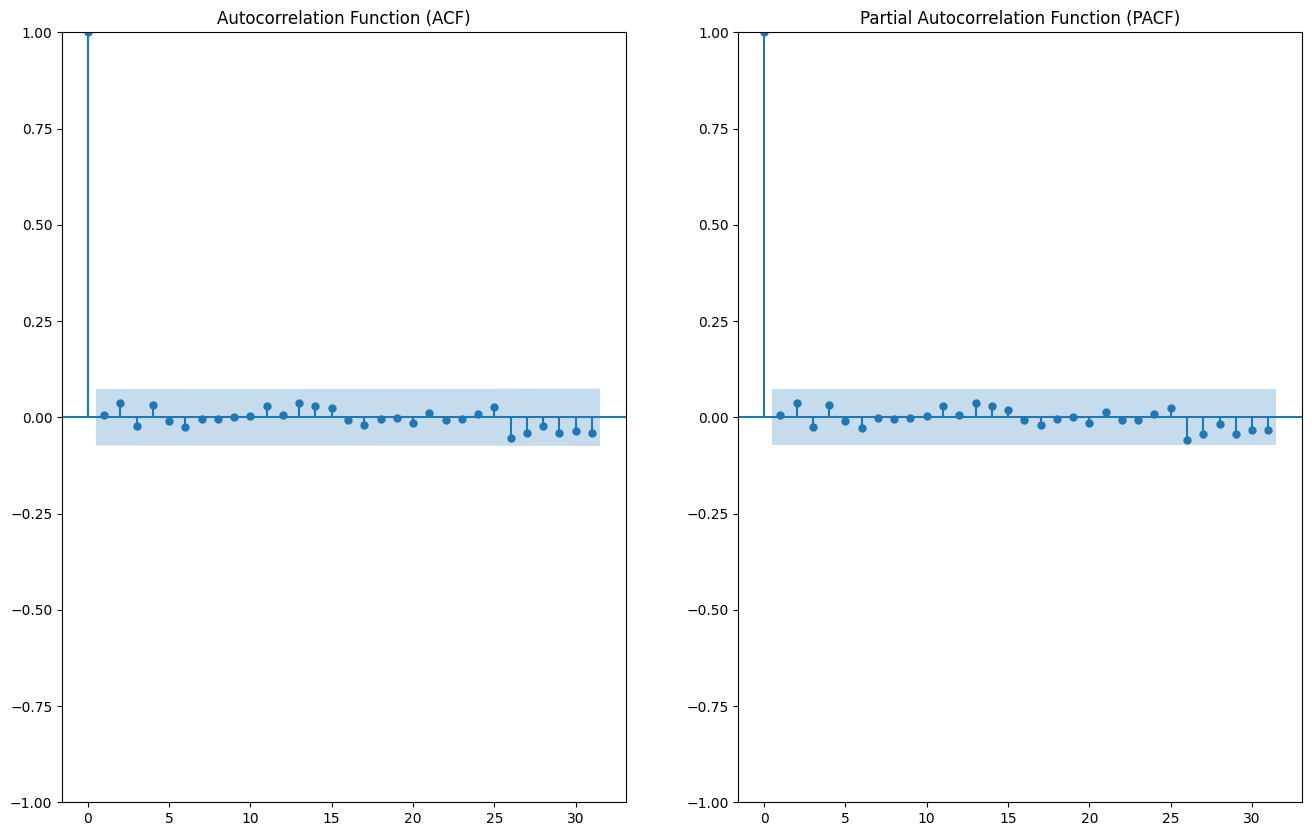

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set figure size
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# ACF plot
plot_acf((pca_tesla**2),alpha = 0.01, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

# PACF plot
plot_pacf((pca_tesla**2),alpha = 0.01, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")


# Show plots
plt.show()


## ADF Test for PCA

In [ ]:
adf_test(pca_tesla)

ADF Statistic: -34.082855671347865
p-value: 0.0
Critical Values:
   1%: -3.4356560275160835
   5%: -2.8638831211270817
   10%: -2.568017509711682
 The series is stationary (reject H0)


In [ ]:
adf_test(tesla_final['log_returns'])

ADF Statistic: -18.87072759647954
p-value: 0.0
Critical Values:
   1%: -3.4356646522289815
   5%: -2.863886926389418
   10%: -2.568019536239491
 The series is stationary (reject H0)


## Plot time series for Tesla log returns

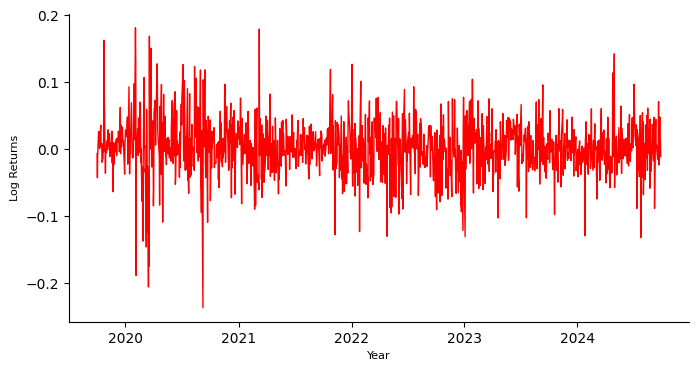

In [313]:
import matplotlib.pyplot as plt

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust size as needed

# Plot the log returns
ax.plot(prices_df['log_returns'], color="red", linewidth=1, label="Log Returns")

# Manually set the background to a subtle grey (like seaborn-darkgrid)
#ax.set_facecolor("#f5f5f5")  

# Remove top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add axis labels
ax.set_xlabel("Year", fontsize=8)
ax.set_ylabel("Log Returns", fontsize=8)

# Add a title
#ax.set_title("Time Series of Log Returns", fontsize=10)

# Customize tick parameters for better readability
ax.tick_params(axis="both", which="major", labelsize=10)

# Add gridlines (light gray for a subtle effect)
#ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7, color="gray")

# Add a legend (optional)
#ax.legend(frameon=False, fontsize=10)

# Show the plot
plt.show()
